In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=5

In [3]:
df=tf.keras.preprocessing.image_dataset_from_directory(
    "plant village",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3478 files belonging to 3 classes.


In [27]:
df

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
df.class_names

['early_blight', 'healthy', 'late_blight']

In [5]:
len(df)

109

In [6]:
for image_batch, label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 2 2 0 0 0 2 1 0 1 1 1 0 2 0 1 0 1 2 0 2 0 2 0 1 2 1 0 1 1 1]


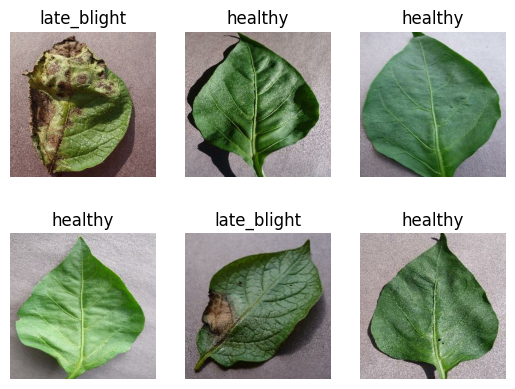

In [7]:
for image_batch, label_batch in df.take(1):
    for i in range(6):
        ax=plt.subplot(2,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(df.class_names[label_batch[i]])
        plt.axis("off")

In [8]:
train_size=0.8
len(df)*train_size

87.2

In [9]:
train_df=df.take(87)
len(train_df)

87

In [10]:
test_df=df.skip(87)
len(test_df)

22

In [11]:
val_df=test_df.take(10)
len(val_df)

10

In [12]:
test_ds=test_df.skip(10)
len(test_ds)

12

In [13]:
def splitting_data(df, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    df_size=len(df)
    if shuffle:
        df=df.shuffle(shuffle_size, seed=12)
    train_size=int(df_size*train_split)
    val_size=int(df_size*val_split)

    train_df=df.take(train_size)
    val_df=df.skip(train_size).take(val_size)
    test_df=df.skip(train_size).skip(val_size)

    return train_df, val_df, test_df 

In [14]:
train_df, val_df, test_df=splitting_data(df)

In [15]:
len(train_df), len(val_df), len(test_df)

(87, 10, 12)

In [16]:
train_df=train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df=val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df=test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['Accuracy']
)

In [23]:
history=model.fit(
    train_df,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_df,
    verbose=1
)

Epoch 1/10


87/87 [==============================] - 183s 2s/step - loss: 0.6767 - Accuracy: 0.6853 - val_loss: 0.6022 - val_Accuracy: 0.7812
Epoch 2/10
87/87 [==============================] - 171s 2s/step - loss: 0.3241 - Accuracy: 0.8720 - val_loss: 0.3959 - val_Accuracy: 0.8625
Epoch 3/10
87/87 [==============================] - 178s 2s/step - loss: 0.2314 - Accuracy: 0.9153 - val_loss: 0.1611 - val_Accuracy: 0.9594
Epoch 4/10
87/87 [==============================] - 171s 2s/step - loss: 0.1731 - Accuracy: 0.9358 - val_loss: 0.1556 - val_Accuracy: 0.9312
Epoch 5/10
87/87 [==============================] - 174s 2s/step - loss: 0.1423 - Accuracy: 0.9510 - val_loss: 0.1337 - val_Accuracy: 0.9563
Epoch 6/10
87/87 [==============================] - 185s 2s/step - loss: 0.1248 - Accuracy: 0.9503 - val_loss: 0.0720 - val_Accuracy: 0.9750
Epoch 7/10
87/87 [==============================] - 171s 2s/step - loss: 0.1539 - Accuracy: 0.9441 - val_loss: 0.1026 - val_Accuracy: 0.9656
Epoch 8/10


In [24]:
scores=model.evaluate(train_df)

87/87 [==============================] - 31s 358ms/step - loss: 0.0660 - Accuracy: 0.9776


In [25]:
scores

[0.06598799675703049, 0.9776496291160583]

In [26]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 87}

In [30]:
history.history.keys()

dict_keys(['loss', 'Accuracy', 'val_loss', 'val_Accuracy'])

In [32]:
accuracy=history.history["Accuracy"]
val_accuracy=history.history["val_Accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

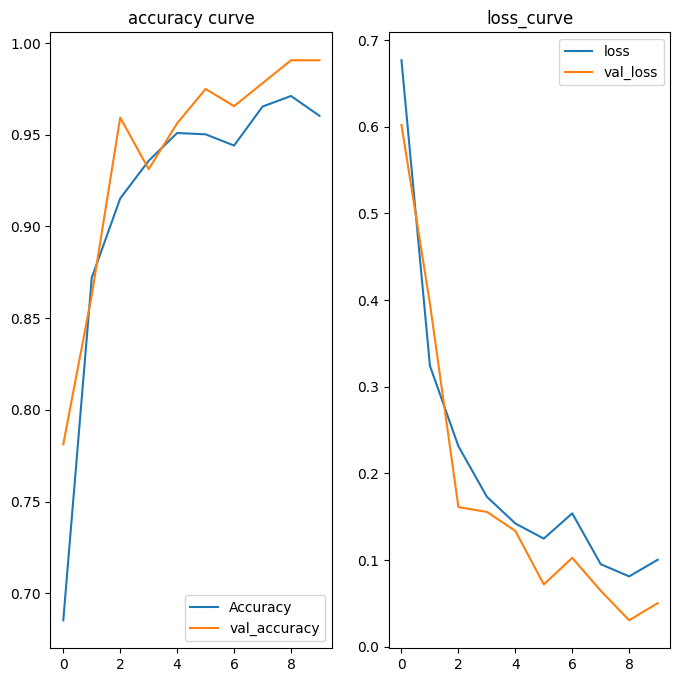

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label="Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label="val_accuracy")
plt.legend(loc="lower right")
plt.title("accuracy curve")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="loss")
plt.plot(range(EPOCHS), val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.title("loss_curve")
plt.show()


first image to be predicted
actual label is: late_blight
1/1 [==============================] - 0s 412ms/step
predicted label is: late_blight


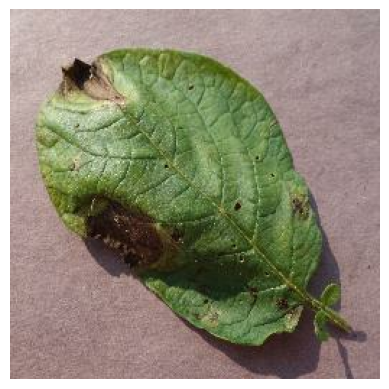

In [54]:
import numpy as np

for images, labels in test_df.take(1):
    first_image=images[0].numpy().astype("uint8")
    first_label=labels[0].numpy()

    print("first image to be predicted")
    
    plt.imshow(first_image)
    plt.axis("off")
    print("actual label is:", df.class_names[first_label])

    batch_predicted=model.predict(images)
    first_predicted_label=np.argmax(batch_predicted[0])
    print("predicted label is:", df.class_names[first_predicted_label])

In [56]:
import pickle
with open("potato disease.pkl", 'wb') as f:
    pickle.dump(model, f)


In [57]:
with open("potato disease.pkl", 'rb') as f:
    model=pickle.load( f)